# CheckV

Compare the quality of viral predictions with checkv.

We ran checkv on every virus, and calculated its _quality_. Per [the CheckV paper](https://www.nature.com/articles/s41587-020-00774-7),  the program classifies each sequence into one of five quality tiers ([Fig. 1](https://www.nature.com/articles/s41587-020-00774-7#Fig1))—complete, high quality (>90% completeness), medium quality (50–90% completeness), low quality (0–50% completeness) or undetermined quality (no completeness estimate available).

The _not determined_ essentially means that there is no similarity in either the 24,834 NCBI GenBank sequences or the 76,262 DTR Viral Contigs, and doesn't mean that things are good or bad


In [1]:
# A lot of this is not used, but we import it so we have it later!
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import numpy as np

import math
import re

from PhiSpyAnalysis import theils_u, DateConverter, printmd
from PhiSpyAnalysis import read_phages, read_gtdb, read_checkv, read_base_pp, read_categories, read_metadata, read_transposons

from scipy.stats import pearsonr, f_oneway
from sklearn.linear_model import LinearRegression
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison
from statsmodels.multivariate.manova import MANOVA

# Read the phage counts

This is our generic reading of phage counts that we use each time.

In [2]:
acccol = 'ncbi_genbank_assembly_accession'

In [3]:
phagesdf = read_phages(maxcontigs=-1)
phagesdf

Please note that this was run with git commit 46ed9e5 that has 567,404 genomes parsed.
Initially there were 3,265,453 kept phages,but after filtering we kept 3,265,453 prophages from 567,399 genomes

,assembly_accession,assembly_name,Genome length,Contigs,Phage Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
0,GCA_000043285.1,ASM4328v1,705557.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0
1,GCA_000046685.1,ASM4668v1,1581384.0,1.0,1.0,18.0,3.0,0.0,15.0,97011.0
2,GCA_000046705.1,ASM4670v1,1931047.0,1.0,1.0,36.0,7.0,0.0,29.0,278490.0
3,GCA_000046845.1,ASM4684v1,3598621.0,1.0,1.0,13.0,3.0,4.0,6.0,83112.0
4,GCA_000047365.1,ASM4736v1,4840898.0,3.0,3.0,22.0,3.0,3.0,16.0,213427.0
...,...,...,...,...,...,...,...,...,...,...
567399,GCA_905187425.1,Xanthomonas_sp._CPBF_424_-_hybrid_assembly,4900930.0,1.0,1.0,46.0,7.0,9.0,30.0,214278.0
567400,GCA_905188235.1,ASM90518823v1,4963609.0,1.0,1.0,29.0,4.0,4.0,21.0,178993.0
567401,GCA_905219375.1,QI0054,3034314.0,1.0,1.0,12.0,4.0,3.0,5.0,178527.0
567402,GCA_905219385.1,QI0055,3034113.0,1.0,1.0,12.0,4.0,3.0,5.0,178526.0


# Read the CheckV output

We have `small` and `regular` datasets. Use the `small` for debugging!

In [4]:
checkv = read_checkv()
checkv

,Prophage,contig_length,gene_count,checkv_quality
0,BX897700.1_PP1,15580,16,Not-determined
1,BX897700.1_PP2,52808,46,Low-quality
2,BX897700.1_PP3,28623,36,Not-determined
3,BX897699.1_PP1,58738,91,Medium-quality
4,BX897699.1_PP2,55416,59,Medium-quality
...,...,...,...,...
3210638,CADILH010000016.1_PP3,23300,26,Not-determined
3210639,CADILL010000001.1_PP1,24881,27,Not-determined
3210640,CADILL010000007.1_PP2,16691,17,Not-determined
3210641,CADILN010000005.1_PP1,18647,22,Low-quality


In [5]:
base_pp = read_base_pp()
base_pp

,assembly_accession,assembly_name,Prophage
0,GCA_000003135.1,ASM313v1,GG666849.1_PP1
1,GCA_000003135.1,ASM313v1,GG666854.1_PP2
2,GCA_000003645.1,ASM364v1,CM000714.1_PP1
3,GCA_000003925.1,ASM392v1,CM000742.1_PP3
4,GCA_000003925.1,ASM392v1,CM000742.1_PP4
...,...,...,...
3131866,GCA_006968265.1,PDT000211423.2,AAGTCL010000038.1_PP6
3131867,GCA_006968265.1,PDT000211423.2,AAGTCL010000039.1_PP7
3131868,GCA_006968265.1,PDT000211423.2,AAGTCL010000003.1_PP2
3131869,GCA_006968265.1,PDT000211423.2,AAGTCL010000041.1_PP8


### Convert the checkv_quality into counts per genome so we can correlate it with other metrics

In [6]:
# start by merging the two dataframes
checkvb = pd.merge(base_pp, checkv, on='Prophage', how='inner')
checkvb

,assembly_accession,assembly_name,Prophage,contig_length,gene_count,checkv_quality
0,GCA_000003135.1,ASM313v1,GG666849.1_PP1,20352,30,Not-determined
1,GCA_000003135.1,ASM313v1,GG666854.1_PP2,28564,28,Low-quality
2,GCA_000003645.1,ASM364v1,CM000714.1_PP1,40297,55,Medium-quality
3,GCA_000003925.1,ASM392v1,CM000742.1_PP3,67074,80,High-quality
4,GCA_000003925.1,ASM392v1,CM000742.1_PP4,79454,82,Medium-quality
...,...,...,...,...,...,...
3084860,GCA_006968265.1,PDT000211423.2,AAGTCL010000038.1_PP6,12989,16,Low-quality
3084861,GCA_006968265.1,PDT000211423.2,AAGTCL010000039.1_PP7,10282,12,Low-quality
3084862,GCA_006968265.1,PDT000211423.2,AAGTCL010000003.1_PP2,91930,112,Medium-quality
3084863,GCA_006968265.1,PDT000211423.2,AAGTCL010000041.1_PP8,5043,7,Low-quality


## Count the number of occurrences

We use the group by to count the number of `checkv_qualities` but then need to reset the indices.

In [7]:
acv = checkvb.groupby(['assembly_accession', 'checkv_quality']).agg({'checkv_quality': 'size'})
acvr = acv.rename({'checkv_quality':'checkv_count'}, axis=1).reset_index()
tmp = acvr[acvr['checkv_quality'] == 'Not-determined'][['assembly_accession', 'checkv_count']].rename({'checkv_count' : 'Not-determined'}, axis=1)
for t in ['Low-quality', 'Medium-quality', 'High-quality', 'Complete']:
    tmp2 = acvr[acvr['checkv_quality'] == t][['assembly_accession', 'checkv_count']].rename({'checkv_count' : t}, axis=1)
    tmp = pd.merge(tmp, tmp2, on='assembly_accession', how='outer')
countdf = tmp.fillna(0)
countdf

,assembly_accession,Not-determined,Low-quality,Medium-quality,High-quality,Complete
0,GCA_000003135.1,1.0,1.0,0.0,0.0,0.0
1,GCA_000003925.1,2.0,2.0,1.0,1.0,0.0
2,GCA_000005825.2,2.0,1.0,0.0,0.0,0.0
3,GCA_000006625.1,1.0,1.0,0.0,0.0,0.0
4,GCA_000006965.1,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
520147,GCA_901305565.1,0.0,0.0,0.0,0.0,1.0
520148,GCA_901319165.1,0.0,0.0,0.0,0.0,1.0
520149,GCA_901325505.1,0.0,0.0,0.0,0.0,1.0
520150,GCA_901331095.1,0.0,0.0,0.0,0.0,1.0


In [8]:
acv = checkvb.groupby(['assembly_accession', 'checkv_quality'], group_keys=False).agg({'checkv_quality': 'size'})
acvr = acv.rename({'checkv_quality':'checkv_count'}, axis=1)
colcountdf = acvr.reset_index()
colcountdf

,assembly_accession,checkv_quality,checkv_count
0,GCA_000003135.1,Low-quality,1
1,GCA_000003135.1,Not-determined,1
2,GCA_000003645.1,Medium-quality,1
3,GCA_000003925.1,High-quality,1
4,GCA_000003925.1,Low-quality,2
...,...,...,...
1330504,GCA_902860175.1,Not-determined,1
1330505,GCA_902860195.1,Low-quality,1
1330506,GCA_902860205.1,Not-determined,2
1330507,GCA_902860235.1,Low-quality,1


## Merge the phage counts and CheckV data

In [9]:
phagesdf

,assembly_accession,assembly_name,Genome length,Contigs,Phage Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
0,GCA_000043285.1,ASM4328v1,705557.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0
1,GCA_000046685.1,ASM4668v1,1581384.0,1.0,1.0,18.0,3.0,0.0,15.0,97011.0
2,GCA_000046705.1,ASM4670v1,1931047.0,1.0,1.0,36.0,7.0,0.0,29.0,278490.0
3,GCA_000046845.1,ASM4684v1,3598621.0,1.0,1.0,13.0,3.0,4.0,6.0,83112.0
4,GCA_000047365.1,ASM4736v1,4840898.0,3.0,3.0,22.0,3.0,3.0,16.0,213427.0
...,...,...,...,...,...,...,...,...,...,...
567399,GCA_905187425.1,Xanthomonas_sp._CPBF_424_-_hybrid_assembly,4900930.0,1.0,1.0,46.0,7.0,9.0,30.0,214278.0
567400,GCA_905188235.1,ASM90518823v1,4963609.0,1.0,1.0,29.0,4.0,4.0,21.0,178993.0
567401,GCA_905219375.1,QI0054,3034314.0,1.0,1.0,12.0,4.0,3.0,5.0,178527.0
567402,GCA_905219385.1,QI0055,3034113.0,1.0,1.0,12.0,4.0,3.0,5.0,178526.0


In [10]:
phagecv = pd.merge(phagesdf, countdf, on='assembly_accession', how='inner')
phagecv

,assembly_accession,assembly_name,Genome length,Contigs,Phage Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage,Not-determined,Low-quality,Medium-quality,High-quality,Complete
0,GCA_000046685.1,ASM4668v1,1581384.0,1.0,1.0,18.0,3.0,0.0,15.0,97011.0,2.0,1.0,0.0,0.0,0.0
1,GCA_000046705.1,ASM4670v1,1931047.0,1.0,1.0,36.0,7.0,0.0,29.0,278490.0,2.0,2.0,3.0,0.0,0.0
2,GCA_000046845.1,ASM4684v1,3598621.0,1.0,1.0,13.0,3.0,4.0,6.0,83112.0,1.0,0.0,0.0,2.0,0.0
3,GCA_000047365.1,ASM4736v1,4840898.0,3.0,3.0,22.0,3.0,3.0,16.0,213427.0,0.0,1.0,0.0,2.0,0.0
4,GCA_000020005.1,ASM2000v1,3191453.0,3.0,3.0,35.0,6.0,5.0,24.0,184247.0,4.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520147,GCA_902860165.1,LMG_6000,7299680.0,55.0,29.0,43.0,3.0,22.0,18.0,94796.0,1.0,1.0,0.0,1.0,0.0
520148,GCA_902860175.1,LMG_5997,7197255.0,38.0,21.0,33.0,2.0,14.0,17.0,69051.0,1.0,0.0,0.0,1.0,0.0
520149,GCA_902860195.1,LMG_7053,6702936.0,200.0,148.0,33.0,1.0,11.0,21.0,12819.0,0.0,1.0,0.0,0.0,0.0
520150,GCA_902860205.1,LMG_6001,6320373.0,36.0,19.0,35.0,2.0,21.0,12.0,41572.0,2.0,0.0,0.0,0.0,0.0


# Plot the quality of predictions against the length of the genome

Here we just use _number of contigs_ as the proxy for "genome quality". We also explore N<sub>50</sub> below, but this is probably the most meaningful plot

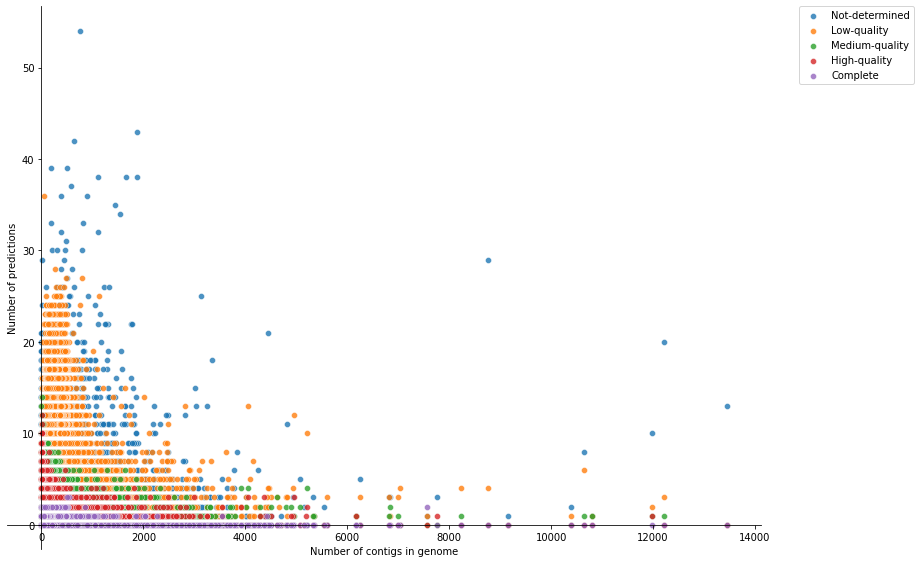

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
cols = ['Not-determined', "Low-quality", "Medium-quality", "High-quality", "Complete"]
#for c in cols:
#    tempdf=phagecv[phagecv['checkv_quality']==c]
#    ax = sns.scatterplot(x='Contigs', y='checkv_count', data=tempdf, label=c, ax=ax, alpha=0.8)

for c in cols:
    ax = sns.scatterplot(x='Contigs', y=c, data=phagecv, label=c, ax=ax, alpha=0.8)

ax.set_ylabel('Number of predictions')
ax.set_xlabel('Number of contigs in genome')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')


plt.tight_layout()
l = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# fig.savefig('images/contigs_checkvqual.svg')

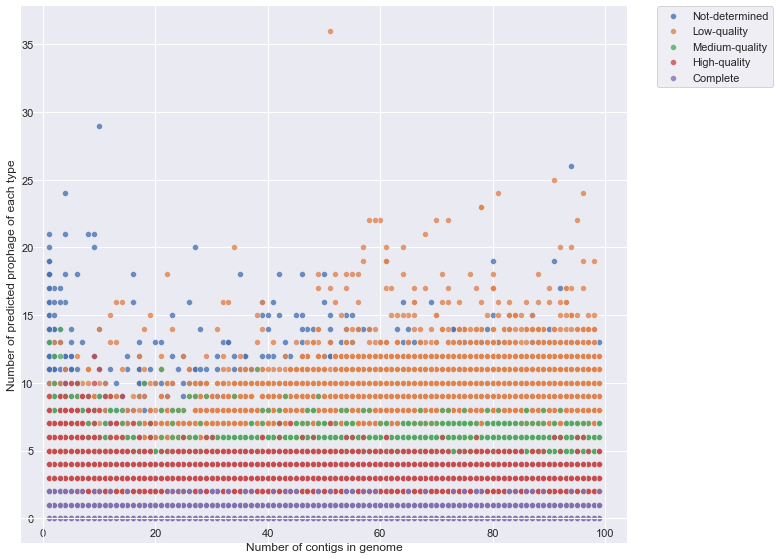

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
cols = ['Not-determined', "Low-quality", "Medium-quality", "High-quality", "Complete"]
#for c in cols:
#    tempdf=phagecv[phagecv['checkv_quality']==c]
#    ax = sns.scatterplot(x='Contigs', y='checkv_count', data=tempdf, label=c, ax=ax, alpha=0.8)

for c in cols:
    ax = sns.scatterplot(x='Contigs', y=c, data=phagecvsm, label=c, ax=ax, alpha=0.8)

ax.set_ylabel('Number of predicted prophage of each type')
ax.set_xlabel('Number of contigs in genome')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.get_legend().set_title("CheckV quality")
l = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.tight_layout()
fig.savefig('images/contigs_checkvqualsm.png')
fig.savefig('images/contigs_checkvqualsm.svg')

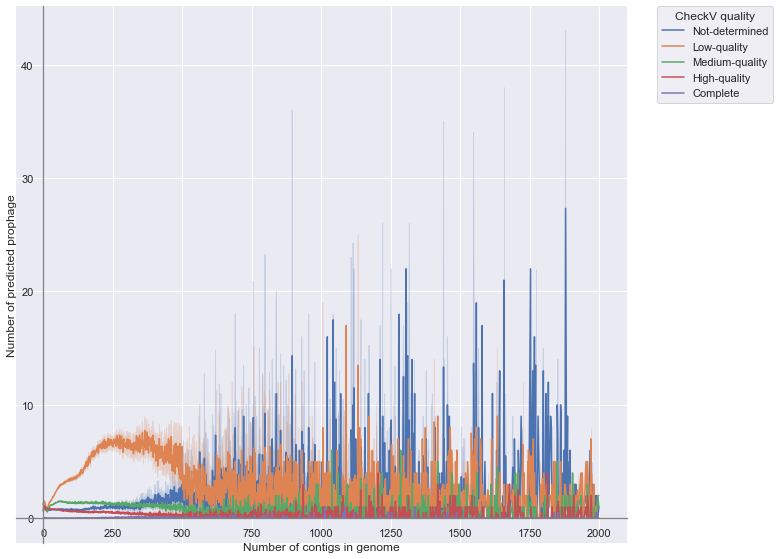

In [43]:
phagecvsm = phagecv[phagecv['Contigs'] < 2000]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
cols = ['Not-determined', "Low-quality", "Medium-quality", "High-quality", "Complete"]

for c in cols:
    ax = sns.lineplot(x='Contigs', y=c, data=phagecvsm, label=c, ax=ax)


ax.set_ylabel('Number of predicted prophage')
ax.set_xlabel('Number of contigs in genome')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
l = plt.legend(title="CheckV quality", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

fig.savefig('images/contigs_checkvqual_lines.png')
fig.savefig('images/contigs_checkvqual_lines.svg')

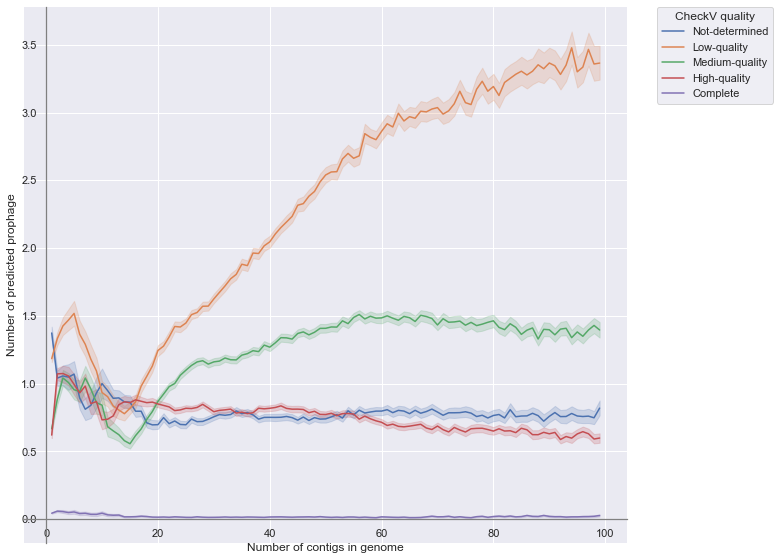

In [42]:
phagecvsm = phagecv[phagecv['Contigs'] < 100]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
cols = ['Not-determined', "Low-quality", "Medium-quality", "High-quality", "Complete"]
#for c in cols:
#    tempdf=phagecv[phagecv['checkv_quality']==c]
#    ax = sns.scatterplot(x='Contigs', y='checkv_count', data=tempdf, label=c, ax=ax, alpha=0.8)

for c in cols:
    ax = sns.lineplot(x='Contigs', y=c, data=phagecvsm, label=c, ax=ax)
    # ax = sns.scatterplot(x='Contigs', y=c, data=phagecvsm, label=c, ax=ax, alpha=0.2)


ax.set_ylabel('Number of predicted prophage')
ax.set_xlabel('Number of contigs in genome')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
l = plt.legend(title="CheckV quality", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

fig.savefig('images/contigs_checkvqualsm_lines.png')
fig.savefig('images/contigs_checkvqualsm_lines.svg')

## Bin the number of contigs per genome

This is another way of visualizing the same data. We create 100bp bins and use `pd.cut` to assign each _number of contigs_ to a bin, and then we can plot the data again

In [12]:
bins = []
for i in range(0,2100,100):
    bins.append(i)

labels = []
for i in range(len(bins)-1):
        labels.append(i)
        # labels.append(f"{bins[i]}-{bins[i+1]}")
phagecv['Contig Bins'] = pd.cut(phagecv['Contigs'], bins=bins, labels=labels)
phagecv

,assembly_accession,assembly_name,Genome length,Contigs,Phage Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage,Not-determined,Low-quality,Medium-quality,High-quality,Complete,Contig Bins
0,GCA_000046685.1,ASM4668v1,1581384.0,1.0,1.0,18.0,3.0,0.0,15.0,97011.0,2.0,1.0,0.0,0.0,0.0,0
1,GCA_000046705.1,ASM4670v1,1931047.0,1.0,1.0,36.0,7.0,0.0,29.0,278490.0,2.0,2.0,3.0,0.0,0.0,0
2,GCA_000046845.1,ASM4684v1,3598621.0,1.0,1.0,13.0,3.0,4.0,6.0,83112.0,1.0,0.0,0.0,2.0,0.0,0
3,GCA_000047365.1,ASM4736v1,4840898.0,3.0,3.0,22.0,3.0,3.0,16.0,213427.0,0.0,1.0,0.0,2.0,0.0,0
4,GCA_000020005.1,ASM2000v1,3191453.0,3.0,3.0,35.0,6.0,5.0,24.0,184247.0,4.0,1.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520147,GCA_902860165.1,LMG_6000,7299680.0,55.0,29.0,43.0,3.0,22.0,18.0,94796.0,1.0,1.0,0.0,1.0,0.0,0
520148,GCA_902860175.1,LMG_5997,7197255.0,38.0,21.0,33.0,2.0,14.0,17.0,69051.0,1.0,0.0,0.0,1.0,0.0,0
520149,GCA_902860195.1,LMG_7053,6702936.0,200.0,148.0,33.0,1.0,11.0,21.0,12819.0,0.0,1.0,0.0,0.0,0.0,1
520150,GCA_902860205.1,LMG_6001,6320373.0,36.0,19.0,35.0,2.0,21.0,12.0,41572.0,2.0,0.0,0.0,0.0,0.0,0


### Plot all the phage quality scores

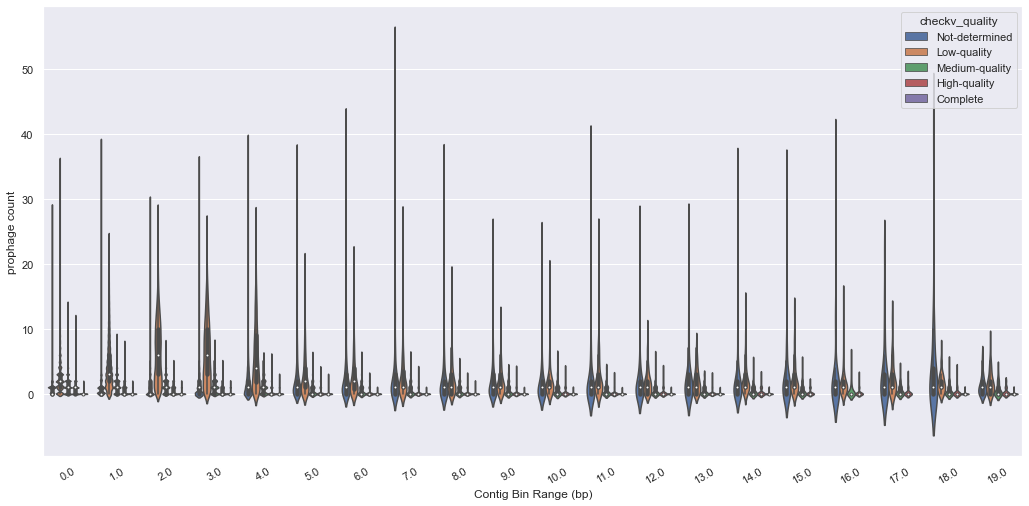

In [13]:
data = []
cols = ['Not-determined', "Low-quality", "Medium-quality", "High-quality", "Complete"]
for index, row in phagecv.iterrows():
    for c in cols:
        if ~np.isnan(row[c]):
            data.append([c, row['Contig Bins'], row[c]])
        

ndf = pd.DataFrame(data, columns=['checkv_quality', 'Contig Bins', 'prophage count'])
sns.set(rc={'figure.figsize':(17.55,8.27)})
ax = sns.violinplot(x='Contig Bins', y='prophage count', hue='checkv_quality', scale='count', jitter=True, data=ndf)
ax.set_xlabel("Contig Bin Range (bp)")
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

### Group the phage qualities into Low and High and just plot those.

Note that this emphasizes the _not determined_ group, but since CheckV doesn't know what they are, I don't think we should continue with them

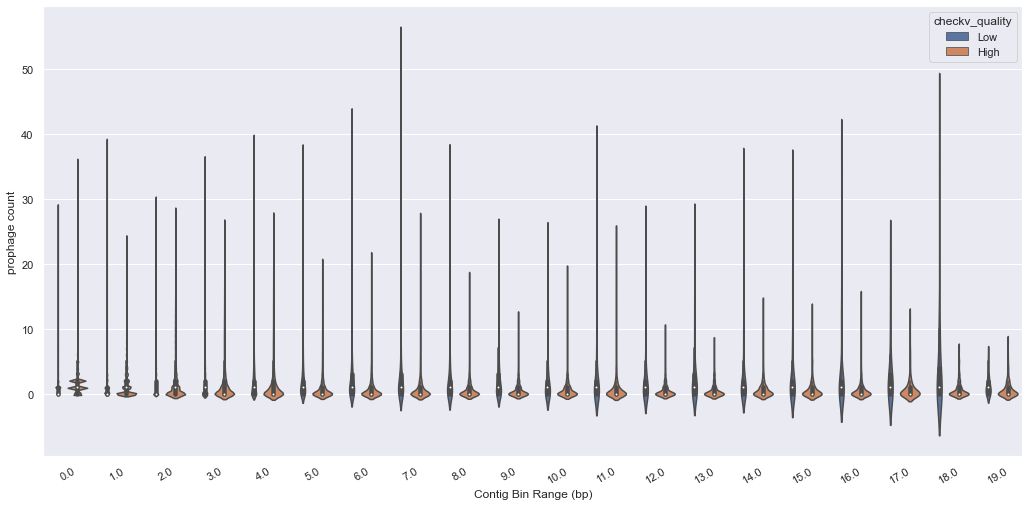

In [14]:
data = []
#cols = ['Not-determined', "Low-quality", "Medium-quality", "High-quality", "Complete"]
cols = {'Not-determined' : "Low", "Low-quality" : "High", "Medium-quality" : "High", "High-quality" : "High", "Complete" : "High"}
for index, row in phagecv.iterrows():
    for c in cols:
        if ~np.isnan(row[c]):
            data.append([cols[c], row['Contig Bins'], row[c]])
        

ndf = pd.DataFrame(data, columns=['checkv_quality', 'Contig Bins', 'prophage count'])
sns.set(rc={'figure.figsize':(17.55,8.27)})
ax = sns.violinplot(x='Contig Bins', y='prophage count', hue='checkv_quality', scale='count', jitter=True, data=ndf)
ax.set_xlabel("Contig Bin Range (bp)")
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

## Read the GTDB data to get N50 etc

In the above panels, we used number of contigs as a proxy for genome quality. We can also use N<sub>50</sub> which is included in the GTDB data table. Here we read that and merge it with our phagecv data.

In [20]:
gtdb = read_gtdb()
contqual = pd.merge(phagecv, gtdb[['assembly_accession', 'n50_contigs']], on='assembly_accession', how='inner')
contqual

,assembly_accession,assembly_name,Genome length,Contigs,Phage Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage,Not-determined,Low-quality,Medium-quality,High-quality,Complete,Contig Bins,n50_contigs
0,GCA_000046685.1,ASM4668v1,1581384.0,1.0,1.0,18.0,3.0,0.0,15.0,97011.0,2.0,1.0,0.0,0.0,0.0,0,1581384
1,GCA_000046705.1,ASM4670v1,1931047.0,1.0,1.0,36.0,7.0,0.0,29.0,278490.0,2.0,2.0,3.0,0.0,0.0,0,1931047
2,GCA_000046845.1,ASM4684v1,3598621.0,1.0,1.0,13.0,3.0,4.0,6.0,83112.0,1.0,0.0,0.0,2.0,0.0,0,3598621
3,GCA_000047365.1,ASM4736v1,4840898.0,3.0,3.0,22.0,3.0,3.0,16.0,213427.0,0.0,1.0,0.0,2.0,0.0,0,4744671
4,GCA_000020005.1,ASM2000v1,3191453.0,3.0,3.0,35.0,6.0,5.0,24.0,184247.0,4.0,1.0,1.0,0.0,0.0,0,3165557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113141,GCA_902158715.1,SB6413,6393461.0,62.0,43.0,31.0,1.0,10.0,20.0,24989.0,0.0,1.0,0.0,0.0,0.0,0,306634
113142,GCA_902158725.1,SB6412,6006767.0,23.0,16.0,25.0,3.0,6.0,16.0,99240.0,0.0,0.0,0.0,2.0,0.0,0,1235124
113143,GCA_902167575.1,B.breve_2_mod_mod2,2406753.0,16.0,12.0,21.0,1.0,1.0,19.0,51094.0,0.0,0.0,1.0,0.0,0.0,0,228906
113144,GCA_902167585.1,Streptococcus_thermophilus_BgEED37_mod2,2310024.0,42.0,32.0,31.0,5.0,5.0,21.0,146320.0,2.0,0.0,2.0,1.0,0.0,0,119921


### Plot Qualities by N<sub>50</sub>

Here we plot the N<sub>50</sub> on the x-axis, the number of prophages on the y-axis, and we colour by the quality of the predictions.

Recall that a higher N<sub>50</sub> is _probably_ better, and a complete genome should have an N<sub>50</sub> between 2 and 5 Mbp!

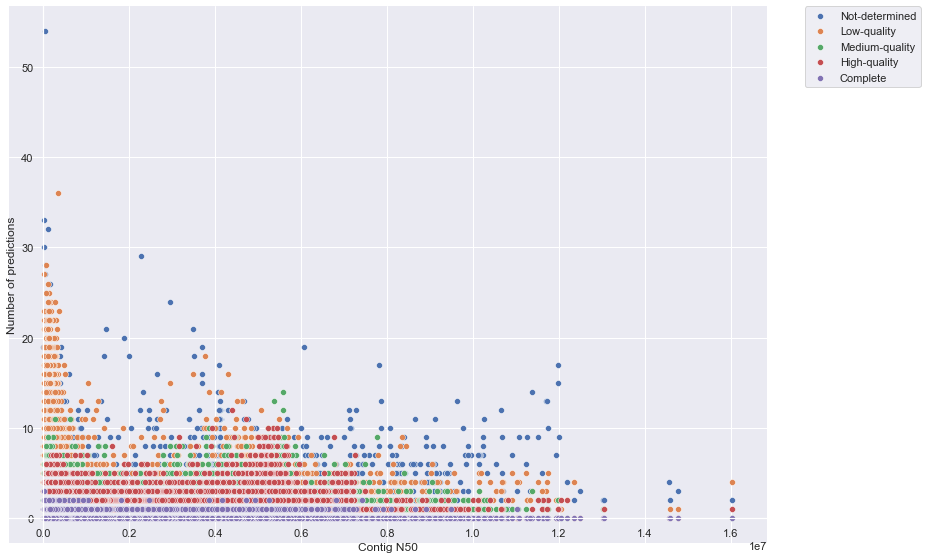

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
cols = ['Not-determined', "Low-quality", "Medium-quality", "High-quality", "Complete"]
for c in cols:
    ax = sns.scatterplot(x='n50_contigs', y=c, data=contqual, label=c, ax=ax)

ax.set_ylabel('Number of predictions')
ax.set_xlabel('Contig N50')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')


plt.tight_layout()
l = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Bin the N<sub>50</sub>

As before, we can create a set of bins and group the data by N<sub>50</sub> bin. 

In [22]:
bins = []
labels = []
for i in range(9):
    bins.append(i * 2e6)
    labels.append(f"{i*2}-{(i+1)*2}")
    #labels.append(f"{i/10}")
labels = labels[:-1]
contqual['n50bins'] = pd.cut(contqual['n50_contigs'], bins=bins, labels=labels)
contqual

,assembly_accession,assembly_name,Genome length,Contigs,Phage Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage,Not-determined,Low-quality,Medium-quality,High-quality,Complete,Contig Bins,n50_contigs,n50bins
0,GCA_000046685.1,ASM4668v1,1581384.0,1.0,1.0,18.0,3.0,0.0,15.0,97011.0,2.0,1.0,0.0,0.0,0.0,0,1581384,0-2
1,GCA_000046705.1,ASM4670v1,1931047.0,1.0,1.0,36.0,7.0,0.0,29.0,278490.0,2.0,2.0,3.0,0.0,0.0,0,1931047,0-2
2,GCA_000046845.1,ASM4684v1,3598621.0,1.0,1.0,13.0,3.0,4.0,6.0,83112.0,1.0,0.0,0.0,2.0,0.0,0,3598621,2-4
3,GCA_000047365.1,ASM4736v1,4840898.0,3.0,3.0,22.0,3.0,3.0,16.0,213427.0,0.0,1.0,0.0,2.0,0.0,0,4744671,4-6
4,GCA_000020005.1,ASM2000v1,3191453.0,3.0,3.0,35.0,6.0,5.0,24.0,184247.0,4.0,1.0,1.0,0.0,0.0,0,3165557,2-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113141,GCA_902158715.1,SB6413,6393461.0,62.0,43.0,31.0,1.0,10.0,20.0,24989.0,0.0,1.0,0.0,0.0,0.0,0,306634,0-2
113142,GCA_902158725.1,SB6412,6006767.0,23.0,16.0,25.0,3.0,6.0,16.0,99240.0,0.0,0.0,0.0,2.0,0.0,0,1235124,0-2
113143,GCA_902167575.1,B.breve_2_mod_mod2,2406753.0,16.0,12.0,21.0,1.0,1.0,19.0,51094.0,0.0,0.0,1.0,0.0,0.0,0,228906,0-2
113144,GCA_902167585.1,Streptococcus_thermophilus_BgEED37_mod2,2310024.0,42.0,32.0,31.0,5.0,5.0,21.0,146320.0,2.0,0.0,2.0,1.0,0.0,0,119921,0-2


### Convert the binned data into a new data frame

Here we make a new data frame so we can group things for the violin plot. 

In [23]:
data = []
cols = ['Not-determined', "Low-quality", "Medium-quality", "High-quality", "Complete"]
for index, row in contqual.iterrows():
    for c in cols:
        if ~np.isnan(row[c]):
            data.append([c, row['n50bins'], row[c]])
        

ndf = pd.DataFrame(data, columns=['checkv_quality', 'N50 bin', 'prophage count'])
ndf

,checkv_quality,N50 bin,prophage count
0,Not-determined,0-2,2.0
1,Low-quality,0-2,1.0
2,Medium-quality,0-2,0.0
3,High-quality,0-2,0.0
4,Complete,0-2,0.0
...,...,...,...
565725,Not-determined,0-2,0.0
565726,Low-quality,0-2,0.0
565727,Medium-quality,0-2,0.0
565728,High-quality,0-2,1.0


### Create a new violin plot of the quality vs the N<sub>50</sub>

This is mostly to please Mike R.

Text(0.5, 0, 'N50 bin range (10^6 bp)')

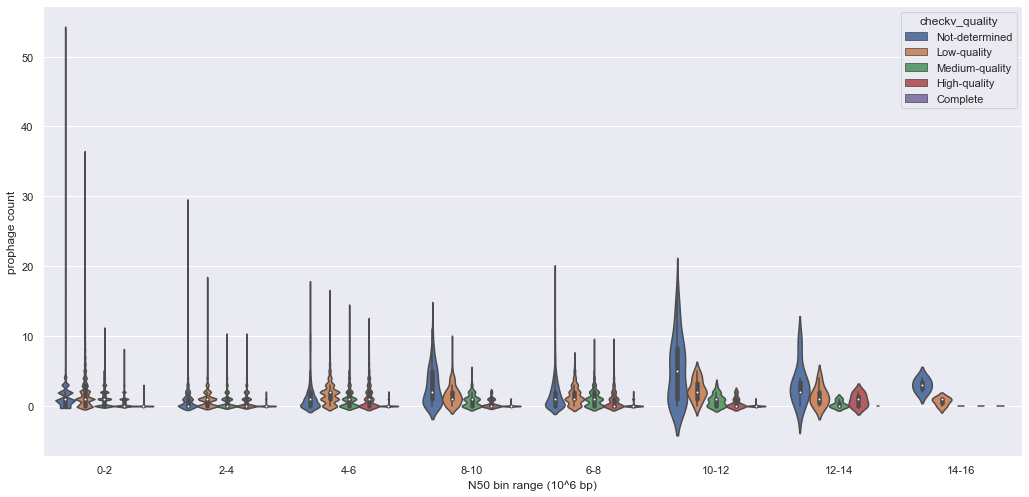

In [24]:
sns.set(rc={'figure.figsize':(17.55,8.27)})
#ax = sns.violinplot(x='N50 bin', y='prophage count', hue='checkv_quality', inner="points", jitter=True, data=ndf)
ax = sns.violinplot(x='N50 bin', y='prophage count', hue='checkv_quality', scale='count', jitter=True, data=ndf)
ax.set_xlabel("N50 bin range (10^6 bp)")
# handles, labels = ax.get_legend_handles_labels()
# l = plt.legend(handles, labels, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)


# Find good quality small phages

This is for Toni Luque who is interested in the sub 10-kb phages

In [25]:
print(f"For the small phages (<6kb) so far, we have {checkv[checkv['contig_length'] < 6000].shape[0]:,} prophages, and these break down into the following checkv quality results:")

For the small phages (<6kb) so far, we have 167,513 prophages, and these break down into the following checkv quality results:


In [26]:
checkv[checkv['contig_length'] < 6000].groupby('checkv_quality').size()

checkv_quality
Complete               2
High-quality           1
Low-quality       138098
Medium-quality       499
Not-determined     28913
dtype: int64

In [28]:
if False:
    checkv[(checkv['contig_length'] < 6000) & ((checkv['checkv_quality'] == 'High-quality') | (checkv['checkv_quality'] == 'Medium-quality'))].to_csv('../data/smallphages.txt', sep="\t")
    printmd("We updated **../data/smallphages.txt** and so now you can run `sbatch smallphages.slurm` on the cluster to make tarballs of those prophage genomes")

<span style='color:black'>We updated **../data/smallphages.txt** and so now you can run `sbatch smallphages.slurm` on the cluster to make tarballs of those prophage genomes</span>